# Vector Embeddings of Log Lines with BERT
This notebook demonstrates the embedding of log line samples into a vector space based on [Sentence-Bert](https://www.sbert.net), an extension to the `BERT` model.

The log line samples orignate from the BGL sample...

These models will be considered in the comparison:
- Model x



# TODO

In [17]:
# TODO: 
# use different transformer model 
# use different log lines (hgdl)

# try t-sne with more complex classes (not only anomaly and non anomaly)
# try to get rid of outliers for max/min values

### Imports

In [2]:
from sentence_transformers import util
import numpy as np
import matplotlib.pyplot as plt

# custom
from src.embedder import get_embedding, get_tsne_embedding
from src.data import pre_process, get_labels, delete_bgl_labels, get_binary_labels, get_idc
from src.utils import get_cosine_distances, get_distance_metrics, get_local_cosine_distances, get_local_distance_metrics

### Data Entry

In [3]:
# set sentence transformer model type
model_name = 'all-mpnet-base-v2'

# set log file and format
log_file   = 'BGL_2k.log'  
log_format = '<Label> <Id> <Date> <Code1> <Time> <Code2> <Component1> <Component2> <Level> <Content>'  # BGL log format

### Pre - Processing

In [4]:
# loads and parses logs with drain logparser
pre_process(log_format, log_file)
labels = get_labels(log_file)
delete_bgl_labels(log_file)

Parsing file: ./logs/BGL_2k.log
Total size after encoding is 2000 2000
Parsing done. [Time taken: 0:00:01.025313]


### Embedding Computation

In [5]:
### code to compute embedding
embedding_processed = get_embedding(log_file, model_name, processed_flag=True, label_flag=True)
embedding_processed_nolabel = get_embedding(log_file, model_name, processed_flag=True, label_flag=False)
embedding_unprocessed = get_embedding(log_file, model_name, processed_flag=False, label_flag=True)
embedding_unprocessed_nolabel = get_embedding(log_file, model_name, processed_flag=False, label_flag=False)


## Evaluation

### Plot functions

In [6]:
def plot_sim_matrix(embeddings, idc: list, labels: list):
    """ plots cosine similarity matrix 
    Params:
        embeddings:
        idc (list[int]): list of indices of log lines that should be included in plot
    """
    plot_logs = []
    cos_scores = util.cos_sim(embeddings, embeddings)

    # convert to numpy to leverage np.ix_function
    # NOTE: conversion leads to loss of accuracy, but for plotting it is ok
    cos_scores_np = cos_scores.numpy()
    sim_matrix = cos_scores_np[np.ix_(idc, idc)]

    # plot
    fig, ax = plt.subplots(figsize=(6,6))
    cax = ax.matshow(sim_matrix, interpolation='nearest')
    plt.title("Cosine Similarity Matrix for Log Lines")
    plt.xticks(range(len(idc)), labels[idc[0]:idc[-1]+1], rotation=90)
    plt.yticks(range(len(idc)), labels[idc[0]:idc[-1]+1])
    fig.colorbar(cax)
    plt.show()

def plot_distance_table(embedding, idc_anomaly, idc_no_anomaly):
    """ plots table with min, max and mean of cos scores for embedding
    Params:
        embedding:
    """

    cos_scores_all, cos_scores_n2n, cos_scores_a2a, cos_scores_n2a = get_cosine_distances(embedding, idc_anomaly, idc_no_anomaly)

    all_min, all_max, all_mean = get_distance_metrics(cos_scores_all)
    n2n_min, n2n_max, n2n_mean = get_distance_metrics(cos_scores_n2n)
    a2a_min, a2a_max, a2a_mean = get_distance_metrics(cos_scores_a2a)
    n2a_min, n2a_max, n2a_mean = get_distance_metrics(cos_scores_n2a)

    cell_text = [
        [all_min, all_max, all_mean],
        [n2n_min, n2n_max, n2n_mean],
        [a2a_min, a2a_max, a2a_mean],
        [n2a_min, n2a_max, n2a_mean]
    ]
    rows = ["all with all", "normal with normal", "anomaly with anomaly", "normal with anomaly"]
    cols = ["Minimum", "Maximum", "Mean"]

    fig, ax = plt.subplots() 
    ax.set_axis_off()        
    the_table = plt.table(cellText=cell_text,
                        rowLabels=rows,
                        colLabels=cols,
                        cellLoc='center',
                        loc='upper left')
    plt.show() 


def plot_local_distance_table(embedding, idc_anomaly, idc_no_anomaly, epsilon):
    """ plots table with min, max and mean of cos scores for embedding
    Params:
        embedding:
    """
    cos_scores_all, cos_scores_n2n, cos_scores_a2a, cos_scores_n2a = get_local_cosine_distances(embedding, idc_anomaly, idc_no_anomaly, epsilon)

    all_min, all_max, all_mean = get_local_distance_metrics(cos_scores_all)
    n2n_min, n2n_max, n2n_mean = get_local_distance_metrics(cos_scores_n2n)
    a2a_min, a2a_max, a2a_mean = get_local_distance_metrics(cos_scores_a2a)
    n2a_min, n2a_max, n2a_mean = get_local_distance_metrics(cos_scores_n2a)

    cell_text = [
        [all_min, all_max, all_mean],
        [n2n_min, n2n_max, n2n_mean],
        [a2a_min, a2a_max, a2a_mean],
        [n2a_min, n2a_max, n2a_mean]
    ]
    rows = ["all with all", "normal with normal", "anomaly with anomaly", "normal with anomaly"]
    cols = ["Minimum", "Maximum", "Mean"]

    fig, ax = plt.subplots() 
    ax.set_axis_off()        
    the_table = plt.table(cellText=cell_text,
                        rowLabels=rows,
                        colLabels=cols,
                        cellLoc='center',
                        loc='upper left')
    plt.show() 


def plot_tsne_embedding(tsne_results, binary_labels, classes):
    """ plots tsne embedding
    Params:
        tsne_results (array[n_samples, n_components]): Embedding of the training data in low-dimensional space.
        binary_labels (list): returns list with entry 0 for no anomaly and 1 for anomaly
        classes (list): string labels for anomaly and no anomaly that are displayed in legend
    """
    plt.figure(figsize=(6,6))
    scatter = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=binary_labels)
    plt.legend(handles=scatter.legend_elements()[0], labels=classes)    
    plt.show()
    

### Plots

#### t-SNE Embedding Plot

/Users/jantiegges/.pyenv/versions/3.8.12/envs/bert-for-log-lines/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/jantiegges/.pyenv/versions/3.8.12/envs/bert-for-log-lines/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


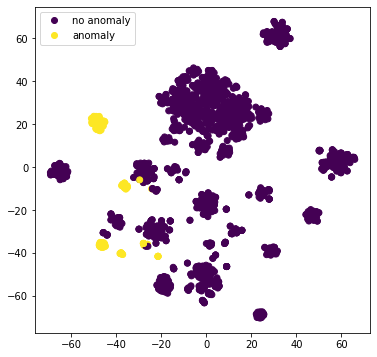

In [7]:
tsne_results = get_tsne_embedding(embedding_processed, n_dim=2)
classes = ["no anomaly", "anomaly"]
binary_labels = get_binary_labels(labels)
plot_tsne_embedding(tsne_results, binary_labels, classes)

# interpretation: seem to tendentially have highest value vor tsne_result[1]
# limitation: tsne better suited for dimensions ~50 so would be better to apply PCA before

#### Cosine Distance Table Comparison

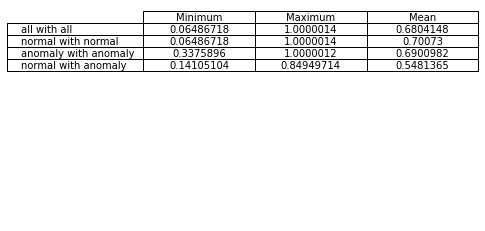

In [9]:
# table of distance metrics

labels = get_labels(log_file)
idc_anomaly, idc_no_anomaly = get_idc(labels)

plot_distance_table(embedding_processed_nolabel, idc_anomaly, idc_no_anomaly)

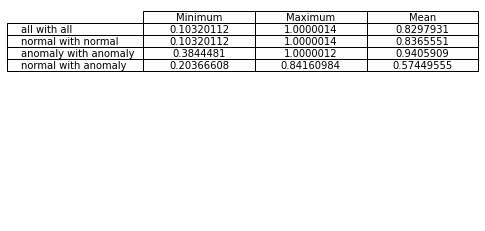

In [10]:
# table of distance metrix for epsilon lines around one line
# might not work for block anomalies (limitation)

labels = get_labels(log_file)
idc_anomaly, idc_no_anomaly = get_idc(labels)

epsilon = 10
plot_local_distance_table(embedding_processed_nolabel, idc_anomaly, idc_no_anomaly, epsilon)

#### Similarity Matrix

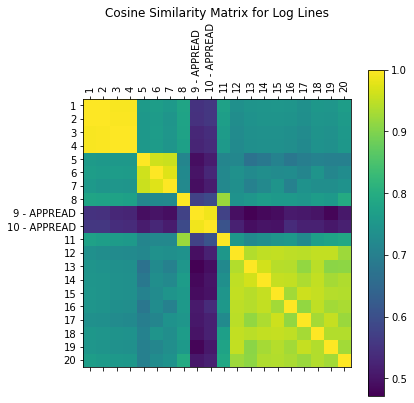

In [14]:
idc = range(0, 20)
plot_sim_matrix(embedding_processed, idc, labels)

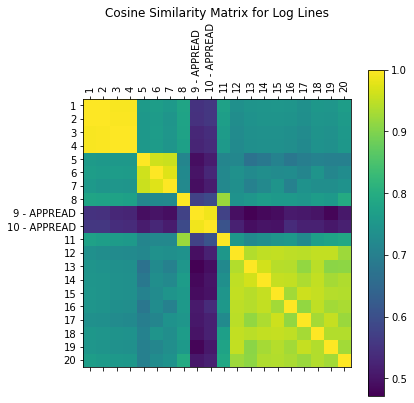

In [15]:
idc = range(20)
plot_sim_matrix(embedding_processed, idc, labels)

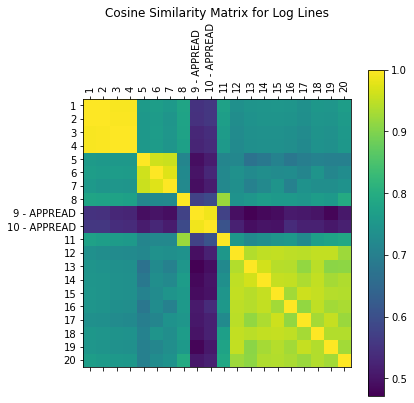

In [16]:
idc = range(20)
plot_sim_matrix(embedding_processed_nolabel, idc, labels)